In [105]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from matplotlib import pyplot as plt

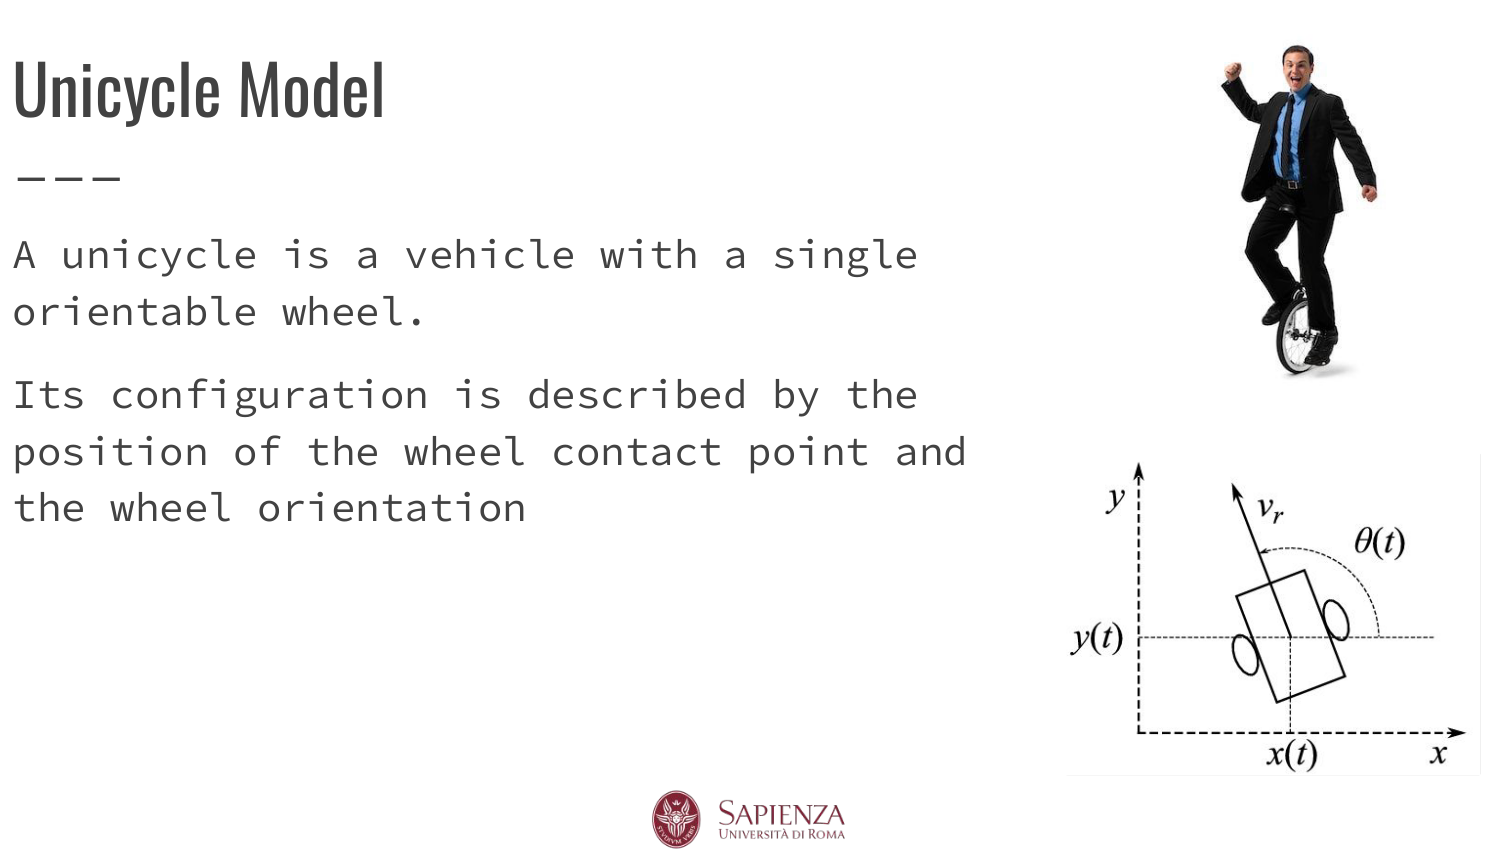

\begin{equation}
    x^{t+1} =  \begin{pmatrix}
                x_1^{t+1}\\
                x_2^{t+1}\\
                x_3^{t+1}\\
                \end{pmatrix} = f(x^{t}, u^{t}) = \begin{pmatrix}
                x_1^{t} + u^{t}_1 \cos(x_3^{t})\delta_t\\
                x_2^{t} + u^{t}_1 \sin(x_3^{t})\delta_t\\
                x_3^{t} + u_2^{t}\delta_t\\
                \end{pmatrix}
\end{equation}

\begin{equation}
    A = \nabla_xf =  \begin{pmatrix}
        1 & 0 & -u^{t}_1 \sin(x_3) \delta_t\\
        0 & 1 & u^{t}_1 \cos(x_3) \delta_t\\
        0 & 0 & 1 \\
    \end{pmatrix}
\end{equation}

\begin{equation}
    B = \nabla_u f =  \begin{pmatrix}
        \cos(x_3) \delta_t & 0\\
        \sin(x_3) \delta_t & 0\\
        0 & \delta_t \end{pmatrix}
\end{equation}

\begin{equation}
    c(x, u) = x^T x + 0.001 u^T u = x_1^2 + x_2^2 + x_3^2 + 0.001 (u_1^2 + u_2^2)
\end{equation}

\begin{equation}
    Q =  \begin{pmatrix}
        1 & 0 & 0\\
        0 & 1 & 0\\
        0 & 0 & 1\end{pmatrix}
\end{equation}

\begin{equation}
    R = \begin{pmatrix}
        0.001 & 0\\
        0 & 0.001\end{pmatrix}
\end{equation}

In [106]:
class UnicycleModel:
    def __init__(self, dt=0.1, max_linear_velocity=2, max_angular_velocity=np.pi/3, action_cost_weight=0.001):
        self.dt = dt
        self.max_linear_velocity = max_linear_velocity
        self.max_angular_velocity = max_angular_velocity
        self.action_cost_weight = action_cost_weight

    def f(self, x, u):
        dt = self.dt
        # clip controls
        u[0] = np.clip(u[0], -self.max_linear_velocity, self.max_linear_velocity)
        u[1] = np.clip(u[1], -self.max_angular_velocity, self.max_angular_velocity)

        x_prime = x.copy()
        # TODO
        x_prime[0] = x_prime[0]+u[0]*np.cos(x_prime[2])*dt
        x_prime[1] = x_prime[1]+u[0]*np.sin(x_prime[2])*dt
        x_prime[2] = x_prime[2]+u[1]*dt
        return x_prime

    def getA(self, x, u):
        dt = self.dt
        # TODO
        A = [1, 0, -u[0]*np.sin(x[2])*dt,
             0, 1,  u[0]*np.cos(x[2])*dt,
             0, 0, 1]
        return A

    def getB(self, x, u):
        dt = self.dt
        # TODO
        B = [np.cos(x[2])*dt, 0,
             np.sin(x[2])*dt, 0,
                0, dt]
        return B

    def getQ(self):
        Q = np.eye(3)
        return Q

    def getR(self):
        R = self.action_cost_weight + np.eye(2)
        return R


def draw_unicycle(x, **kwargs):
    # function to calculate transformation of unicycle reference frame
    get_T = lambda x, y, theta: np.array([[np.cos(theta),-np.sin(theta), x], [np.sin(theta),np.cos(theta), y], [0,0,0]])

    # function to get point from unicycle reference frame to world one
    def get_point(T, x,y):
        x,y,_ = T@(np.array([[x,y,1]]).T).reshape(-1)
        return x,y

    x,y,theta = x
    T = get_T(x,y,theta)
    points = [(0.1,0),(0,-0.05),(0,0.05),(0.1,0)]
    points = [get_point(T,*p) for p in points]
    plt.plot([p[0] for p in points], [p[1] for p in points], **kwargs)


class UnicycleEnv:

    def __init__(self, sigma=0., max_steps=None, **model_args):
        self.model = UnicycleModel(**model_args)
        self.sigma = sigma
        self.max_steps = max_steps

    def reset(self, state=None):
        if state is None:
            state = np.array([0., 0., 0.])
        self.x = state.copy()
        self.steps = 0
        return self.x

    def step(self, u):
        self.x = self.model.f(self.x, u) + np.random.normal(0, self.sigma, 3)
        term = False
        trunc = self.steps >= self.max_steps if self.max_steps is not None else False
        self.steps += 1
        return self.x.copy(), 0, term, trunc

    def render(self, x=None, **kwargs):
        kwargs['color'] = kwargs.get('color', 'red')
        draw_unicycle(x if x is not None else self.x, **kwargs)

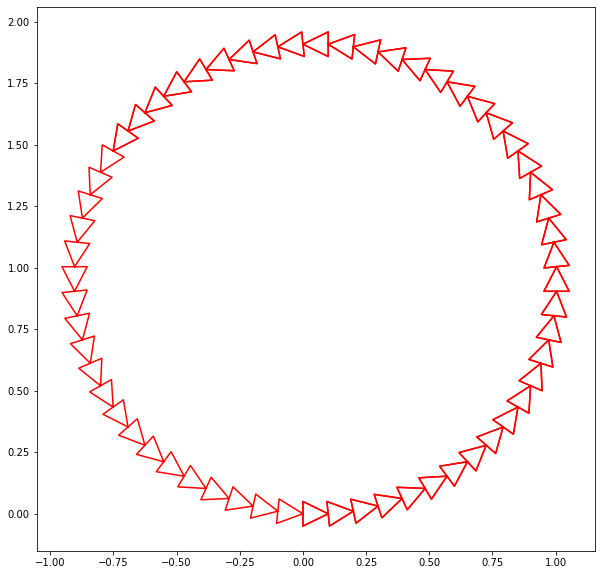

In [107]:
env = UnicycleEnv(dt=0.1)

u = np.array([1,np.pi/3])

plt.subplots(figsize=(10,10))
env.reset()
for i in range(100):
    env.render()
    env.step(u)

plt.show()


# LQR-LTV

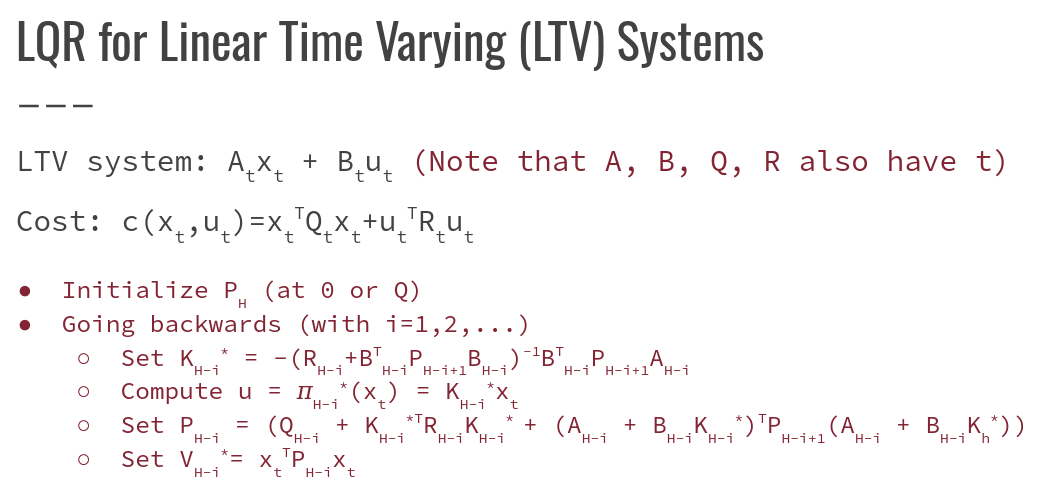

In [ ]:
class LQR:

    def __init__(self, model, horizon=100, u_max=None):
        self.model = model
        self.horizon = horizon
        self.u_max = u_max

    def backward(self, xs, us):
        Qt = self.model.getQ()
        Rt = self.model.getR()

        Ks = []

        Pt1 = Qt
        for t in range(self.horizon-2, -1, -1):
            xt = xs[t]
            ut = us[t]

            At = self.model.getA(xt, ut)
            Bt = self.model.getB(xt, ut)

            Bt = np.array(Bt).reshape((3,2))
            At = np.array(At).reshape((3,3))


            # TODO 
            # SOLUZIONE
            Kt = -np.linalg.inv(Rt + Bt.T @ Pt1 @ Bt) @ (Bt.T @ Pt1 @ At) 

            np.array(Kt).reshape((2,3))
            print(Kt)
            # TODO 
            Pt = (Qt + Kt.T @ Rt @ Kt + (At + Bt @ Kt).T @ Pt1 @ (At + Bt @ Kt))


            Pt1 = Pt

            Ks.append(Kt)

        Ks.reverse()

        return Ks

    def forward(self, xs, us, Ks):
        xs1 = np.array(xs)
        us1 = np.array(us)
        for t in range(len(us)):

            # TODO 
            us1[t] = us[t]+ Ks[t]@(xs1[t]- xs[t])
            # clip controls to the actual range from gymnasium
            if self.u_max is not None:
                us1[t] = np.clip(us1[t], -self.u_max, self.u_max)
            xs1[t+1] = self.model.f(xs1[t], us1[t])

        return xs1, us1



# Iterative LQR (iLQR)

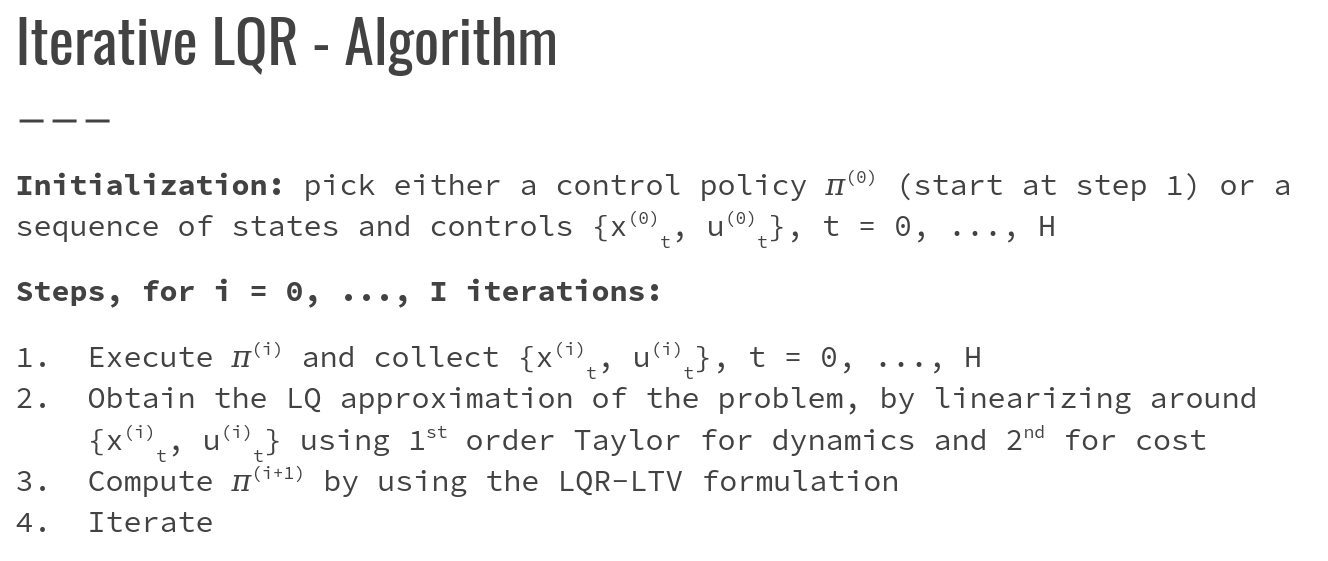

In [109]:
def ilqr(lqr, xs_nom, us_nom, iters=100):
    xs, us = xs_nom.copy(), us_nom.copy()
    for i in range(iters):
        Ks = lqr.backward(xs, us)
        xs, us = lqr.forward(xs, us, Ks)
    return xs, us, Ks

def ilqr_episode(env, xs_nom, us_nom, sigma=0., render=False, lqr_iters=100):
    u_max = np.array([env.model.max_linear_velocity, env.model.max_angular_velocity])
    lqr = LQR(env.model, horizon=len(xs_nom), u_max=u_max)

    render_alpha = 1.0

    total_reward = 0.0
    env.sigma = np.array(sigma)
    state = env.reset(xs_nom[0])

    if render:
        plt.subplots(figsize=(10, 10))
        env.render(alpha=render_alpha)

    xs, us, Ks = ilqr(lqr, xs_nom, us_nom, iters=lqr_iters)

    for xt, ut, Kt, x_nom in zip(xs, us, Ks, xs_nom):
        control = ut + Kt @ (state - xt)

        next_state, reward, term, trunc = env.step(control)

        # print(f's = {state}, u = {control}, r = {reward}, s1 = {next_state}')
        if render:
            # plot nominal trajectory
            draw_unicycle(x_nom, color='green', alpha=render_alpha)
            # plot actual trajectory
            env.render(alpha=render_alpha)

        state = next_state
        total_reward += reward
        if term or trunc:
            break
    if render:
        # plot initial and final states for reference
        draw_unicycle(xs_nom[0], color='blue')
        draw_unicycle(xs_nom[-1], color='yellow')
        plt.show()

    return total_reward


# Test by Following a Random Trajectory

In [110]:
# generate a random trajectory by sampling random "smooth" controls from a random initial state
np.random.seed(0)
horizon = 100
xs_nom = np.zeros((horizon+1, 3))
us_nom = np.zeros((horizon, 2))
scale = 0.5
direction = 1.
steer = 1.
for t in range(horizon):
    scale += 0.01*np.random.random() # accelerate/decelerate smoothly
    if np.random.uniform() < 0.1: # probability of changing direction (forward/backward)
        direction = -direction
    if np.random.uniform() < 0.1: # probability of changing steering
        steer = -steer
    us_nom[t] = np.array([direction*scale, steer*scale*np.pi/6], dtype=np.float32)
    xs_nom[t+1] = env.model.f(xs_nom[t], us_nom[t])

[[-1.52102690e-02  9.77355838e-02  9.78358705e-05]
 [ 1.50447764e-05 -9.66721897e-05 -9.89120651e-02]]
[[-0.03998669  0.19079355 -0.00031299]
 [-0.00965301 -0.00170432 -0.19687268]]
[[-0.04390032  0.28301908  0.00126931]
 [-0.02822761 -0.00565871 -0.29383734]]
[[-0.03738081  0.37010578  0.00414738]
 [-0.05528261 -0.0097852  -0.38968154]]
[[-0.02113848  0.45027137  0.0085309 ]
 [-0.08998562 -0.01295753 -0.48415904]]
[[ 0.0039895   0.52220686  0.01452267]
 [-0.13098353 -0.01411251 -0.57685349]]
[[ 0.0367554   0.58505106  0.02068042]
 [-0.1770121  -0.01234647 -0.63291464]]
[[ 0.07615479  0.63837937  0.02181397]
 [-0.10216195 -0.01260649 -0.66383492]]
[[ 0.12130825  0.68210813  0.01833665]
 [-0.02416885 -0.0165036  -0.7054451 ]]
[[ 0.1710888   0.71641574  0.01075044]
 [ 0.05565453 -0.02467469 -0.75611917]]
[[ 2.24277290e-01  7.41683147e-01 -3.16433378e-04]
 [ 1.35658590e-01 -3.75432669e-02 -8.13933972e-01]]
[[ 0.27983898  0.75838556 -0.00593582]
 [ 0.21396338 -0.05527455 -0.83572977]]
[[ 0

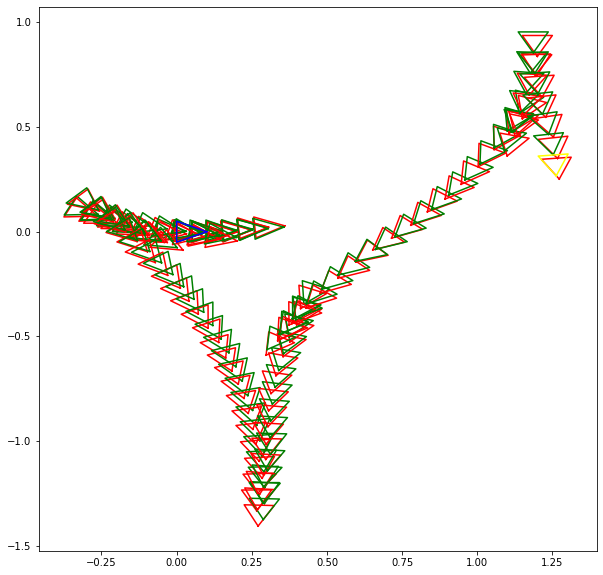

In [111]:
total_reward = ilqr_episode(env, xs_nom, us_nom, sigma=0.005*np.array([1,1,np.pi/16]), render=True, lqr_iters=200)